# This does not work yet!

In [1]:
import theano
import numpy as np
import matplotlib.pylab as plt
import csv, os, random, sys
%matplotlib inline

import lasagne
from lasagne.layers.normalization import BatchNormLayer
from lasagne.layers import Conv2DLayer, InputLayer, ConcatLayer
from lasagne.layers import DenseLayer, Pool2DLayer, FlattenLayer

print "theano",theano.version.full_version
print "lasagne",lasagne.__version__

Mapped name None to device cuda0: GeForce GTX TITAN X
PCI Bus ID: 0000:06:00.0
Using cuDNN version 5105 on context None

theano 0.9.0dev4.dev-255aca76a09593f9806a02e53bea002a973f533e
lasagne 0.2.dev1


In [2]:
#Set seed for random numbers:
np.random.seed(1234)
lasagne.random.set_rng(np.random.RandomState(1234))

In [3]:
##Uncomment these lines to fetch the dataset
#!wget -c http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
#!tar -xvf cifar-10-python.tar.gz

In [4]:
data_dir_cifar10 = os.path.join(".", "cifar-10-batches-py")

def one_hot(x, n):
    x = np.array(x)
    assert x.ndim == 1
    return np.eye(n)[x]

def _load_batch_cifar10(filename, dtype='float32'):
    path = os.path.join(data_dir_cifar10, filename)
    batch = np.load(path)
    data = batch['data'] / 255.0 # scale between [0, 1]
    labels = one_hot(batch['labels'], n=10) # convert labels to one-hot representation
    return data.astype(dtype), labels.astype(dtype)

def cifar10(dtype='float32', grayscale=True):
    x_train = []
    t_train = []
    for k in xrange(5):
        x, t = _load_batch_cifar10("data_batch_%d" % (k + 1), dtype=dtype)
        x_train.append(x)
        t_train.append(t)

    x_train = np.concatenate(x_train, axis=0)
    t_train = np.concatenate(t_train, axis=0)

    x_test, t_test = _load_batch_cifar10("test_batch", dtype=dtype)

    if grayscale:
        x_train = _grayscale(x_train)
        x_test = _grayscale(x_test)

    return x_train, t_train, x_test, t_test

# load data
x_train, t_train, x_test, t_test = cifar10(dtype=theano.config.floatX,grayscale=False)
labels_test = np.argmax(t_test, axis=1)

print "x_train.shape:",x_train.shape

# reshape data
x_train = x_train.reshape((x_train.shape[0], 3, 32, 32))
x_test = x_test.reshape((x_test.shape[0], 3, 32, 32))


x_train.shape: (50000, 3072)


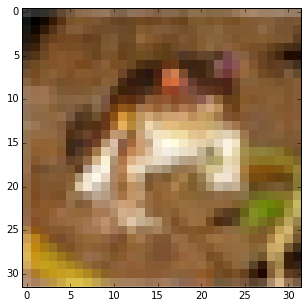

In [5]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 5)
plt.imshow(np.transpose(x_train[0], (1,2,0)),interpolation='none', cmap='gray');

In [6]:
import theano
import theano.tensor as T
import lasagne
import lasagne.layers
from lasagne.layers.normalization import BatchNormLayer
from lasagne.layers import InputLayer, Conv2DLayer, Pool2DLayer, DenseLayer, MaxPool2DLayer
from lasagne.layers import ConcatLayer, DropoutLayer, ReshapeLayer, TransposedConv2DLayer

In [115]:
input_data = T.tensor4('cifar10')
input_var_ex = T.ivector('input_var_ex')

inshape = (None, 3, 32,32)
numhidden = 2

def ConvFactory(data, num_filter, filter_size, stride=1, pad=(0, 0), nonlinearity=lasagne.nonlinearities.rectify):
    data = lasagne.layers.batch_norm(Conv2DLayer(
        data, num_filters=num_filter,
        filter_size=filter_size,
        stride=stride, pad=pad,
        nonlinearity=nonlinearity,
        W=lasagne.init.GlorotUniform(gain='relu')))
    return data

def DeConvFactory(data, num_filter, filter_size, stride=1, pad=(0, 0), nonlinearity=lasagne.nonlinearities.rectify):
    data = lasagne.layers.batch_norm(TransposedConv2DLayer(
        data, num_filters=num_filter,
        filter_size=filter_size, stride=stride, crop=pad,
        nonlinearity=nonlinearity,
        W=lasagne.init.GlorotUniform(gain='relu')))
    return data

net = InputLayer(shape=inshape, input_var=input_data[input_var_ex])
print net.output_shape
l_in = net

net = ConvFactory(data=net, filter_size=3, pad='valid', num_filter=100) 
print net.output_shape

net = ConvFactory(data=net, filter_size=3, pad='valid', num_filter=50, stride=2) 
print net.output_shape

net = ConvFactory(data=net, filter_size=3, pad='valid', num_filter=50, stride=2) 
print net.output_shape


net_before_hidden = net

##########

net = FlattenLayer(net)  
net = lasagne.layers.DenseLayer(net, num_units=numhidden,
                                     W=lasagne.init.GlorotUniform(),
                                     nonlinearity=None)
l_hidden = net

print net.output_shape


numfilters = 50
size = 6
net = lasagne.layers.DenseLayer(net, num_units=numfilters*size*size,
                                     W=lasagne.init.GlorotUniform(),
                                     nonlinearity=None)

net = ReshapeLayer(net, ([0],numfilters,size,size))
print net.output_shape

##########

net = DeConvFactory(data=net, filter_size=4, pad='valid', num_filter=50, stride=2) 
print net.output_shape

net = DeConvFactory(data=net, filter_size=4, pad='valid', num_filter=100, stride=2) 
print net.output_shape

net = DeConvFactory(data=net, filter_size=3, pad='valid', num_filter=3, nonlinearity=lasagne.nonlinearities.sigmoid)
print net.output_shape
    
l_out = net

(None, 3, 32, 32)
(None, 100, 30, 30)
(None, 50, 14, 14)
(None, 50, 6, 6)
(None, 2)
(None, 50, 6, 6)
(None, 50, 14, 14)
(None, 100, 30, 30)
(None, 3, 32, 32)


In [116]:
target_var = T.matrix('targets')

prediction = lasagne.layers.get_output(l_out)
prediction = prediction.clip(0,1)
hidden = lasagne.layers.get_output(l_hidden)

#define how to make prediction
ae_reconstruct = theano.function(
    inputs=[input_var_ex],
    outputs=prediction,
    givens={input_data: x_train}
)

#define how to output embedding
ae_embed = theano.function(
    inputs=[input_var_ex],
    outputs=lasagne.layers.get_output(l_hidden),
    givens={input_data: x_train}
)

ae_reconstruct_test = theano.function(
    inputs=[input_var_ex],
    outputs=prediction,
    givens={input_data: x_test}
)

In [117]:
batch_size = 100
ae_embedding = np.array([])
for i in range(0,len(x_train),batch_size):
    ae_embedding = np.append(ae_embedding, ae_embed(range(i,i+batch_size)))

ae_embedding = ae_embedding.reshape((len(x_train), numhidden))

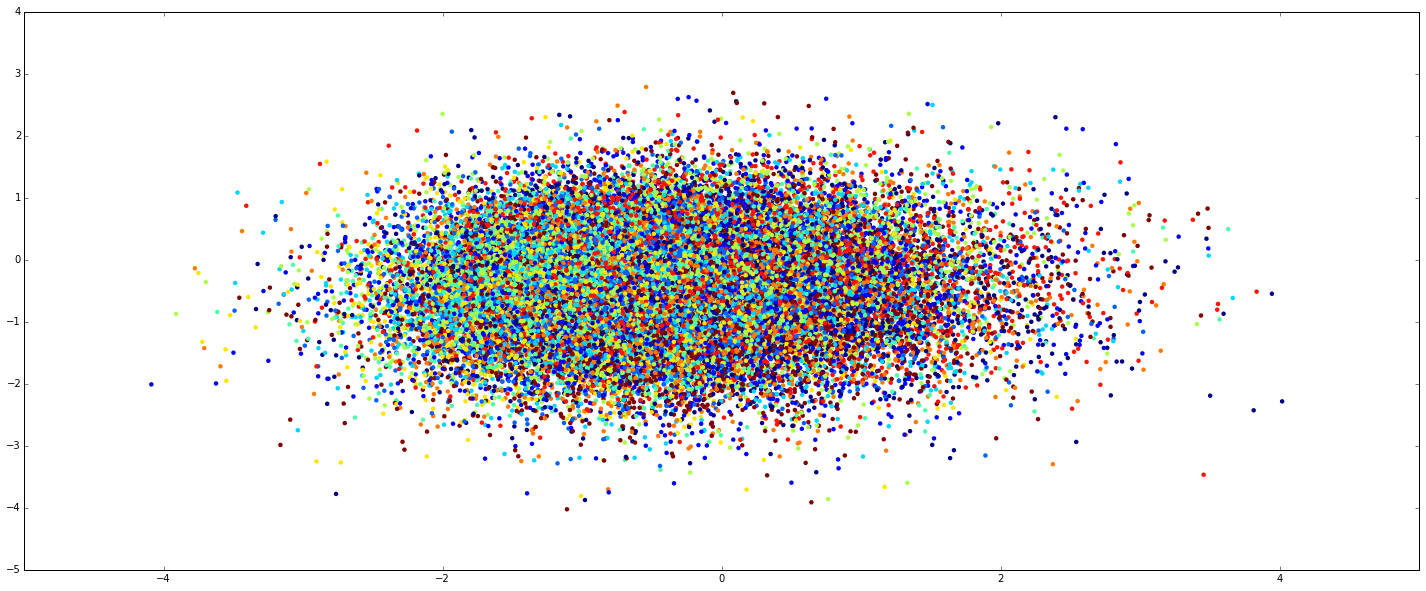

In [118]:
plt.rcParams['figure.figsize'] = (25, 10)
plt.scatter(ae_embedding[:, 0], ae_embedding[:, 1], lw=0,c=np.argmax(t_train, axis=1));

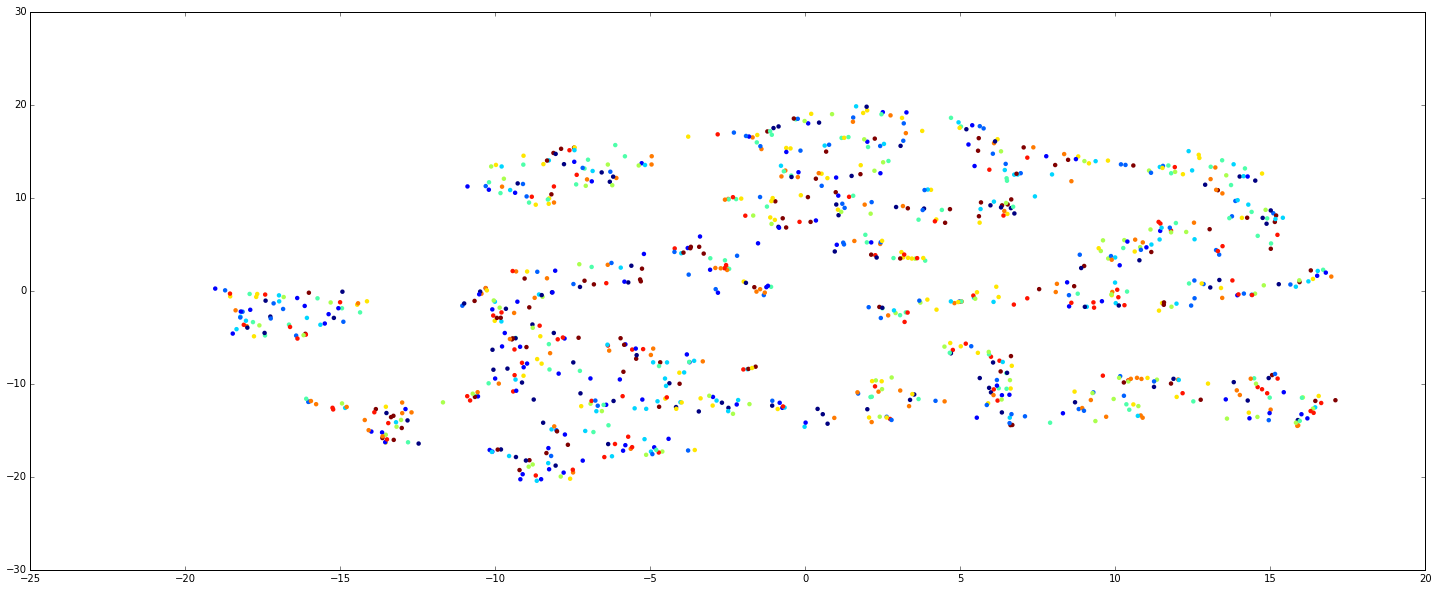

In [119]:
import sklearn.manifold
coor_tsne = sklearn.manifold.TSNE(n_components=2).fit_transform(ae_embedding[:1000])
plt.rcParams['figure.figsize'] = (25, 10)
plt.scatter(coor_tsne[:, 0], coor_tsne[:, 1], lw=0, c=np.argmax(t_train, axis=1)[:1000]);

In [120]:
# create train functions 
lr = theano.shared(np.array(0., dtype=theano.config.floatX))

params_ae = lasagne.layers.get_all_params(l_out, trainable=True)

target_var = T.ivector('target')
rloss = lasagne.objectives.squared_error(prediction,input_data[input_var_ex]).mean()

updates_ae = lasagne.updates.adam(rloss, params_ae, learning_rate=lr)
f_train_ae = theano.function([input_var_ex], 
                          [rloss],
                          updates=updates_ae,
                          givens={input_data: x_train},
                          allow_input_downcast=True)

In [121]:
f_train_ae([0,1])

[array(0.08345808833837509, dtype=float32)]

In [147]:
lr.set_value(0.00001)
batch_size = 256
print "batch_size",batch_size

best_valid_error = 9999999.

for j in range(5000):
    
    batch_err = []  
    
    # shuffle batches
    todo = range(len(x_train))
    random.shuffle(todo)
    
    for i in range(0,len(x_train),batch_size):
        examples = todo[i:i+batch_size]
        err = f_train_ae(examples)
        batch_err.append(err)
        
    err_result = np.asarray(batch_err).mean(axis=0)
    
    
    ### Test error
    ae_reconstruction = np.array([])
    for i in range(0,len(x_test),batch_size):
        ae_reconstruction = np.append(ae_reconstruction, ae_reconstruct_test(range(i,min(i+batch_size,len(x_test)))))

    ae_reconstruction = ae_reconstruction.reshape((len(x_test), 3, 32, 32))
    valid_error = ((ae_reconstruction - x_test)**2).mean()
    
    best_valid_error = min(best_valid_error,valid_error)
    
    if j % 1 == 0:    
        print j, err_result, valid_error, best_valid_error


batch_size 256
0 [ 0.03675617] 0.0369740889787 0.0369740889787
1 [ 0.0367443] 0.0369869918085 0.0369740889787
2 [ 0.03675741] 0.0369788435073 0.0369740889787
3 [ 0.03675996] 0.0369851394272 0.0369740889787
4 [ 0.03675636] 0.0369695980486 0.0369695980486
5 [ 0.03675869] 0.0369907444272 0.0369695980486
6 [ 0.03674004] 0.036975000686 0.0369695980486
7 [ 0.03673354] 0.0369850329932 0.0369695980486
8 [ 0.03676042] 0.0369763443577 0.0369695980486
9 [ 0.03673711] 0.0369793637977 0.0369695980486


KeyboardInterrupt: 

In [158]:
batch_size = 256
ae_embedding = np.array([])
for i in range(0,len(x_train),batch_size):
    ae_embedding = np.append(ae_embedding, ae_embed(range(i,min(i+batch_size,len(x_train)))))

ae_embedding = ae_embedding.reshape((len(x_train), numhidden))

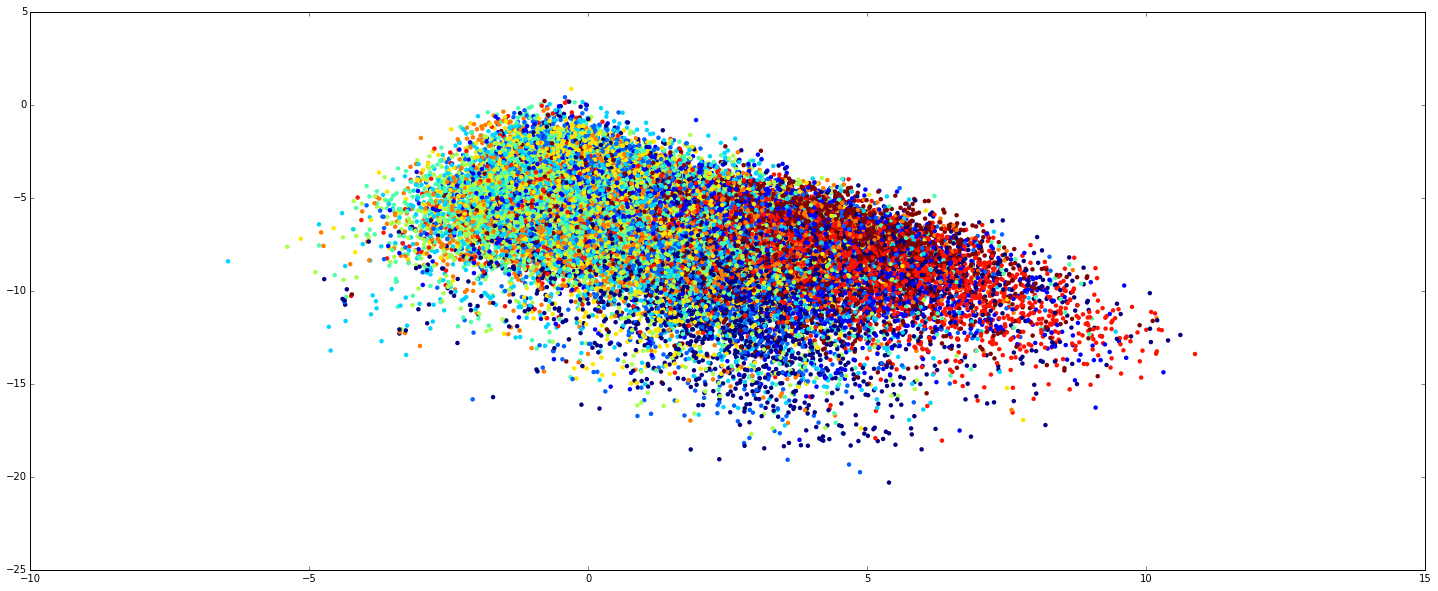

In [159]:
plt.rcParams['figure.figsize'] = (25, 10)
plt.scatter(ae_embedding[:, 0], ae_embedding[:, 1], lw=0,c=np.argmax(t_train, axis=1));

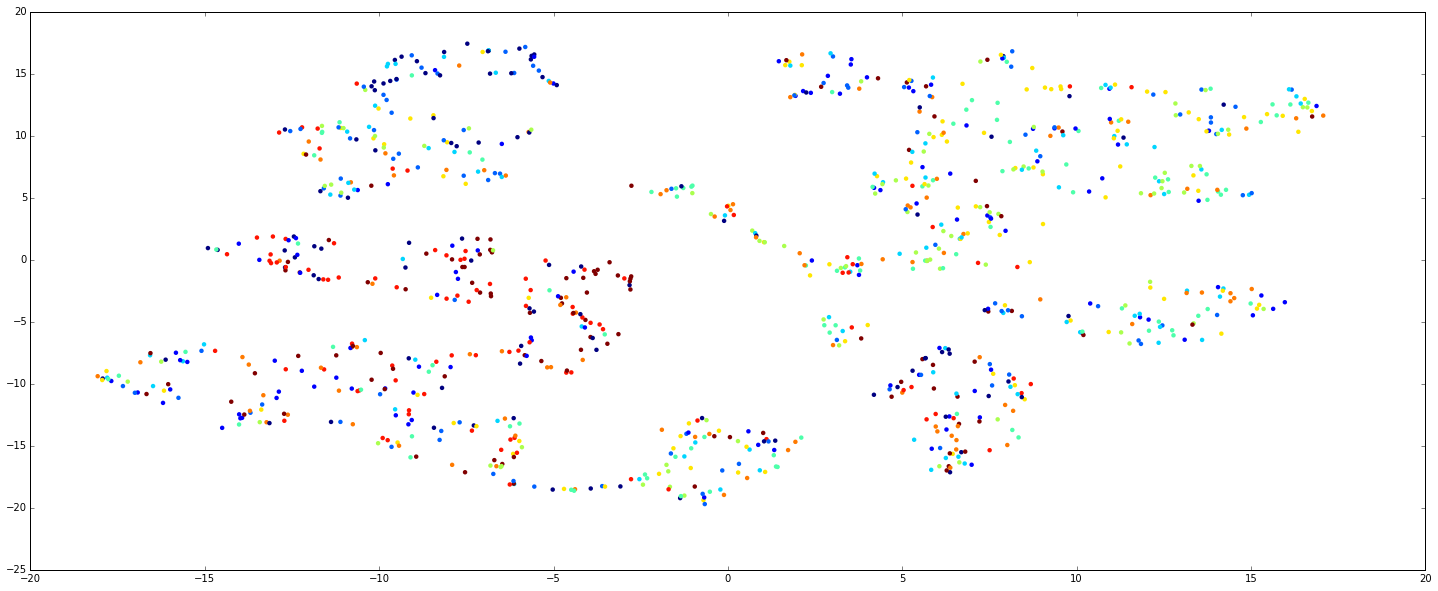

In [160]:
import sklearn.manifold
coor_tsne = sklearn.manifold.TSNE(n_components=2).fit_transform(ae_embedding[:1000])
plt.rcParams['figure.figsize'] = (25, 10)
plt.scatter(coor_tsne[:, 0], coor_tsne[:, 1], lw=0, c=np.argmax(t_train, axis=1)[:1000]);

In [161]:
ae_reconstruction = ae_reconstruct(range(0,batch_size))

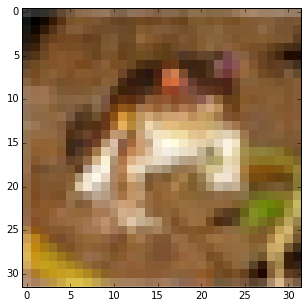

In [162]:
plt.rcParams['figure.figsize'] = (25, 5)
plt.imshow(np.transpose(x_train[0], (1,2,0)),interpolation='none', cmap='gray');

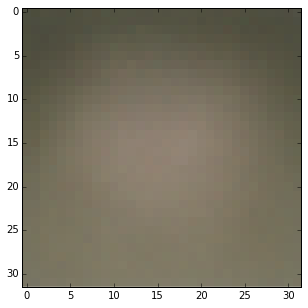

In [163]:
plt.rcParams['figure.figsize'] = (25, 5)
plt.imshow(np.transpose(ae_reconstruction[0], (1,2,0)),interpolation='none', cmap='gray');

In [164]:
ae_reconstruction = ae_reconstruct_test(range(0,batch_size))

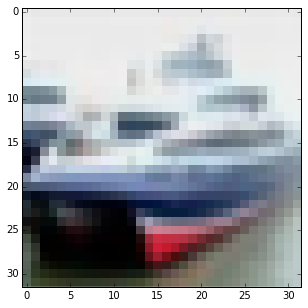

In [165]:
plt.rcParams['figure.figsize'] = (25, 5)
plt.imshow(np.transpose(x_test[1], (1,2,0)),interpolation='none', cmap='gray');

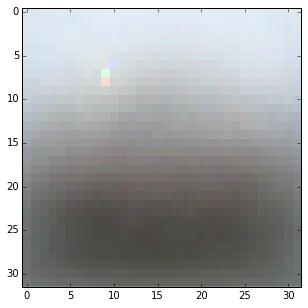

In [166]:
plt.rcParams['figure.figsize'] = (25, 5)
plt.imshow(np.transpose(ae_reconstruction[1], (1,2,0)),interpolation='none', cmap='gray');